This is based on the examples of Chapter 8 in the Ivezic textbook. Have a look there if for another implementation.

In [1]:
import numpy as np
import pylab as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

In [2]:
from astropy.cosmology import LambdaCDM
from astroML.datasets import generate_mu_z
import astroML.linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

In [3]:
z_sample, mu_sample, dmu = generate_mu_z(100,random_state=1234)

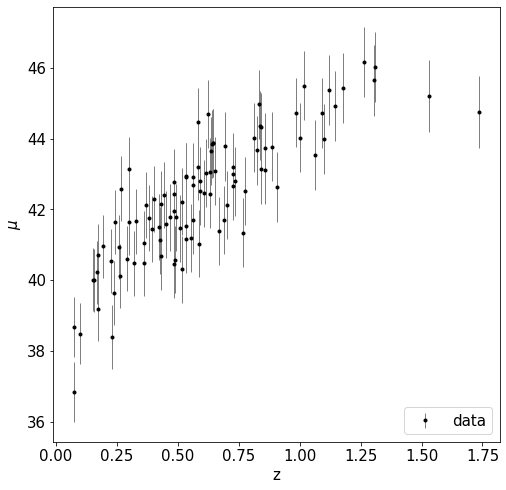

In [4]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
#plt.xlim(0,2)
#plt.ylim(35,50)

I know the true distribution of this, you didn't...

In [5]:
classifier = astroML.linear_model.LinearRegression()

(35.0, 50.0)

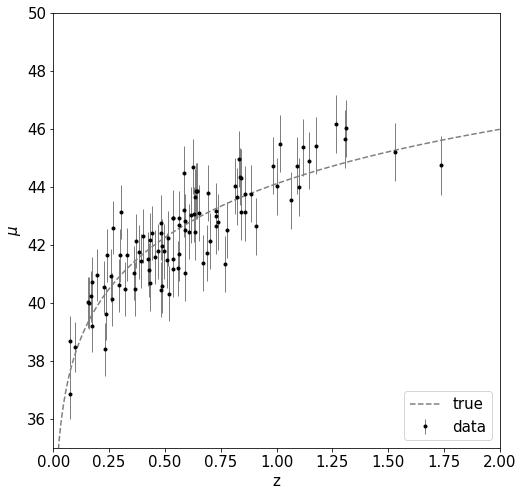

In [6]:
cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=1-0.27)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z, mu_true, '--', c='gray',label='true')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# Part 2. GPR and non-linear model fitting

### Gaussian Process Regression


In [7]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.gaussian_process import GaussianProcessRegressor


kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gp = GaussianProcessRegressor(kernel=kernel, 
                              alpha=dmu ** 2)

gp.fit(z_sample[:, None], mu_sample)
mu_fit, sigma = gp.predict(z[:, None], 
                           return_std=True)

(35.0, 50.0)

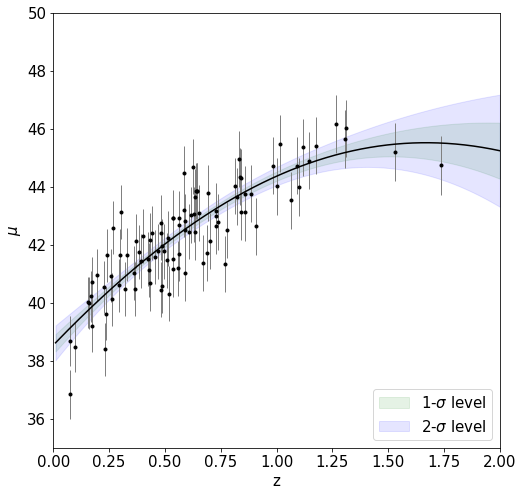

In [8]:
mu_fit = gp.predict(z[:,np.newaxis])

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

plt.plot(z, mu_fit, '-k')

plt.fill_between(z, mu_fit - sigma, 
                mu_fit + sigma,
                alpha=0.1, color='g', 
                label='1-$\sigma$ level')

plt.fill_between(z, mu_fit - 2* sigma, 
                mu_fit + 2* sigma,
                alpha=0.1, color='b', 
                label='2-$\sigma$ level')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

This is gorgeous! The expectation value (black) matches the data very well, and the uncertanties correctly conveys the feeling we had last time that the large-redshift limit is poorly constrained

**Important** My kernel choice has 2 parameters that I had to tweak manually before getting a nice fit. In reality you'll want to do it with cross validation like we did last time.

**Conclusions** GPR is great by not always practicable.

## Bayesian parameter estimation

In [9]:
import emcee
import scipy.stats as scistats
import corner
import dynesty

From the expressions in Hogg 2010 I got

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

but, in general, I never trust my math. If someone trustworthy already implemented it, why should I re-invent the wheel? I'm going to use `distmod` from `astropy.cosmology`. So my generative model will be:

In [10]:
def generativemodel(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value #note I added .value here. Astropy units can be funny.

In [11]:
## Just checking it works
generativemodel(np.random.uniform(0,2,10), 50, 0.1)

array([40.58365473, 42.79269637, 46.47892395, 45.43063961, 42.27333885,
       46.507492  , 46.5503685 , 42.54346024, 46.04437279, 45.17541594])

I take my likelihood to be gaussian. Good thing to do if you don't know anything else (like in this case, I didn't tell you otherwise). 

In [12]:
def LogLikelihood(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = generativemodel(z_sample, H0, Om)
    
    #return np.sum(scistats.norm.logpdf(mu_sample, loc=mu_model, scale=dmu))
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))


### Let's try with MCMC first

In [13]:

def Logprior(theta):
    Om,H0 = theta
    if 50 < H0 < 100 and 0.1 < Om < 1:
        return 0.0
    return -np.inf

                   
def LogPosterior(theta):
    return LogLikelihood(theta) + Logprior(theta)


In [14]:
ndim = 2  # number of parameters in the model
nwalkers = 5  # number of MCMC walkers
nsteps = int(1e4)  # number of MCMC steps to take **for each walker**

starting_guesses = np.array([0.5,80]) + 1e-1* np.random.randn(nwalkers, ndim)


print(starting_guesses.shape)

(5, 2)


In [15]:
# This takes a while...

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps)

print("done")

done


In [16]:
samples = sampler.get_chain()


In [17]:
tau = sampler.get_autocorr_time()
print(tau)

[41.67798943 45.8332411 ]


In [18]:
samples.shape

(10000, 5, 2)

In [19]:
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(1095, 2)


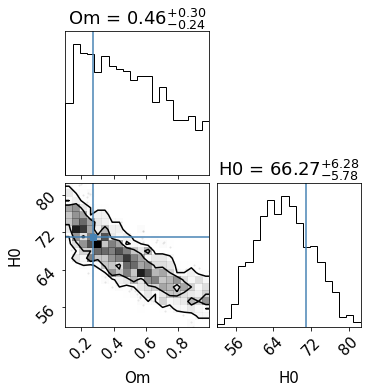

In [20]:
fig = corner.corner(
    flat_samples, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);

In [21]:
zlin = np.linspace(0,2,100)[1:]

(35.0, 50.0)

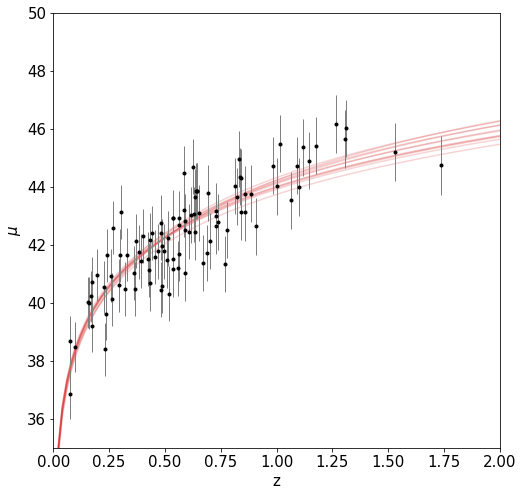

In [22]:
for Om,H0, in flat_samples[::100]:
    plt.plot(zlin, generativemodel(zlin, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
    

### And this is nested sampling:

In [23]:
ndims  =2 

def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    mins = np.array([0.1,30])
    maxs = np.array([1,100])
        
    return  mins + u*(maxs-mins)

In [24]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(LogLikelihood, ptform, ndim,nlive=1000)
sampler.run_nested()
sresults = sampler.results

2761it [00:29, 94.17it/s, +1000 | bound: 0 | nc: 1 | ncall: 16296 | eff(%): 23.079 | loglstar:   -inf < -132.814 <    inf | logz: -135.281 +/-  0.027 | dlogz:  0.001 >  1.009]


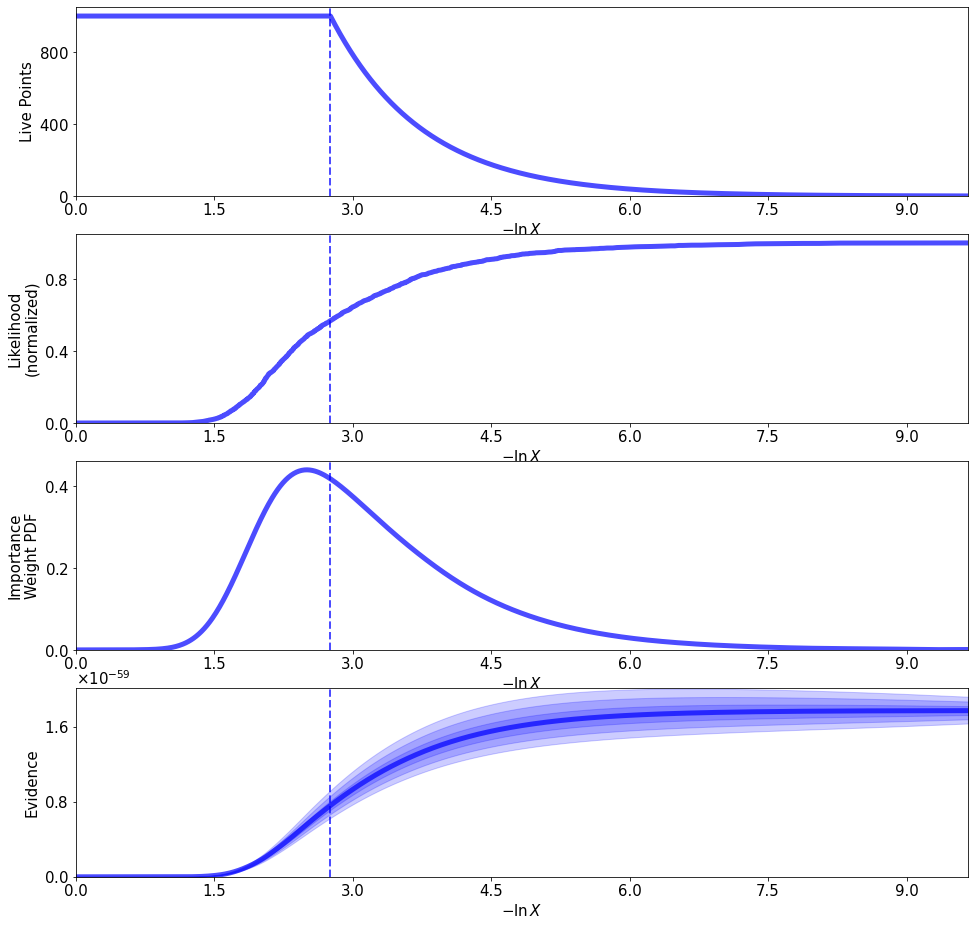

In [25]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

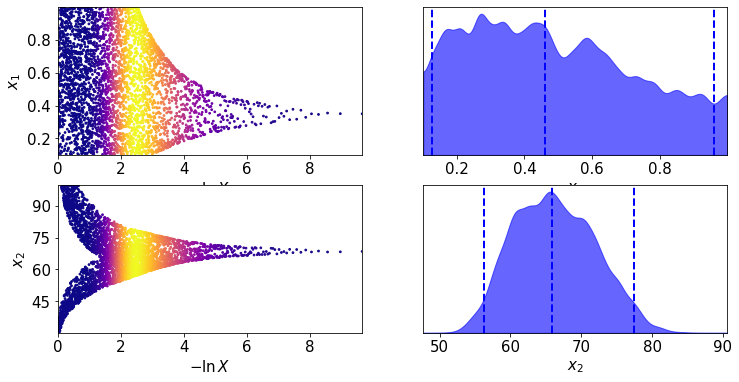

In [26]:
tfig, taxes = dyplot.traceplot(sresults)

In [27]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights)
             for samps in samples.T]
print('68% parameter credible regions are:\n ' + str(quantiles) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(sresults)

68% parameter credible regions are:
 [[0.22297123192747412, 0.7675917587427833], [60.26430059967684, 72.22191639389729]]

Mean and covariance of parameters are: [ 0.48761556 66.22582712]
[[ 0.05744874 -1.16516018]
 [-1.16516018 32.5313943 ]]


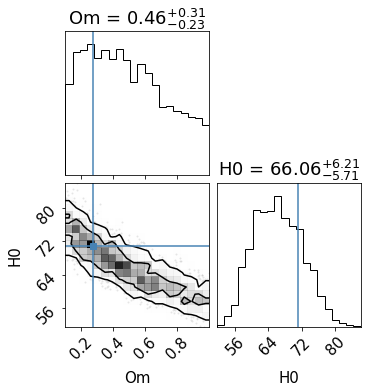

In [28]:
fig = corner.corner(
    samples_equal, labels=["Om","H0"], levels=[0.68,0.95], show_titles=True, truths=[0.27,71]
);

(35.0, 50.0)

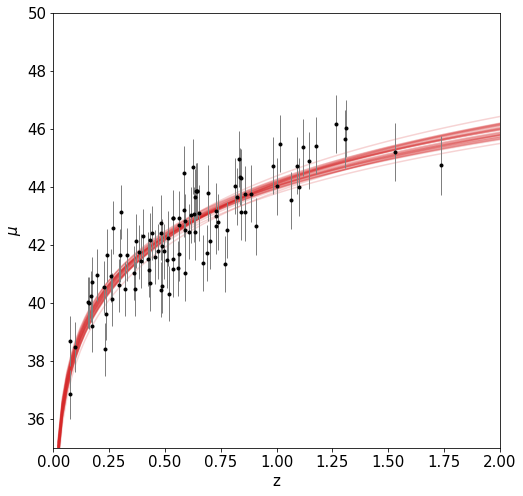

In [29]:
for Om,H0, in samples_equal[::100]:
    plt.plot(zlin, generativemodel(zlin, H0, Om),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
    

Done! We've measured the cosmological parameters!


#### Thoughts

- I would like to check the importance of those last data points
- There is clearly a preferred direction in the $H_0$, $\Omega_m$ plan. Did anyone try to apply a PCA-like algorithm? If yes, what did you find?


### Do we need dark enenrgy?
 
Let's try to fit a model without any dark energy.


In [30]:

def LogLikelihood_mod(theta):

    H0 = float(theta)    
    Om=1
    mu_model = generativemodel(z_sample, H0, Om)
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

ndim  =1

def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    mins = np.array([30.])
    maxs = np.array([100.])
        
    return  mins + u*(maxs-mins)

In [31]:
# "Static" nested sampling.
sampler_mod = dynesty.NestedSampler(LogLikelihood_mod, ptform, ndim,nlive=1000)
sampler_mod.run_nested()
sresults_mod = sampler_mod.results

2749it [00:29, 93.17it/s, +1000 | bound: 0 | nc: 1 | ncall: 16669 | eff(%): 22.491 | loglstar:   -inf < -133.530 <    inf | logz: -135.901 +/-    nan | dlogz:  0.001 >  1.009]


In [32]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults_mod.samples  # samples
weights = np.exp(sresults_mod.logwt - sresults_mod.logz[-1])  # normalized weights

# Resample weighted samples.
samples_equal_mod = dyfunc.resample_equal(samples, weights)

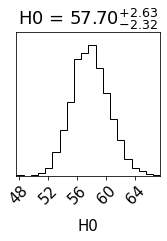

In [33]:
fig = corner.corner(
    samples_equal_mod, labels=["H0"], levels=[0.68,0.95], show_titles=True, truths=[71]
);

(35.0, 50.0)

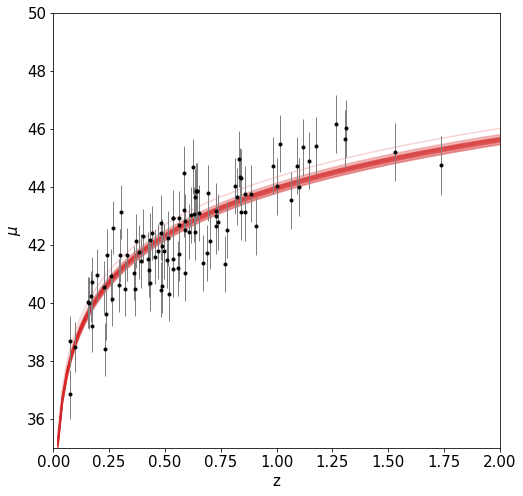

In [34]:
for H0 in samples_equal_mod[::100]:
    plt.plot(zlin, generativemodel(zlin, float(H0), 1),c='C3',alpha=0.2)
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)

Note that a fit does not look so bad. One might be tempted to say we don't need dark energy after all!

In [35]:
np.exp(sampler.results.logz[-1])/np.exp(sampler_mod.results.logz[-1])

1.8590918177412716

Indeed, the Bayes factor is inconclusive. **With this data**, we can't really tell if we live in a Universe without dark energy and $H_0\sim 60$ or in a Universe with $H_0\sim 70$ and 70\% of dark energy.

### Generate mock data (cloning)

Let's use our fits to clone the data now

In [40]:
samples_equal[np.random.choice(samples_equal.shape[0])]

array([ 0.65500748, 58.58337151])

In [41]:
z_vals=np.random.uniform(0,2,1000)
mu_nested=[]
mu_gpr=[]
for z in z_vals:
    Om,H0 = samples_equal[np.random.choice(samples_equal.shape[0])]
    mu_nested.append(generativemodel(z,H0,Om))
    
    
    mu_fit, sigma = gp.predict([[z]], 
                           return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))

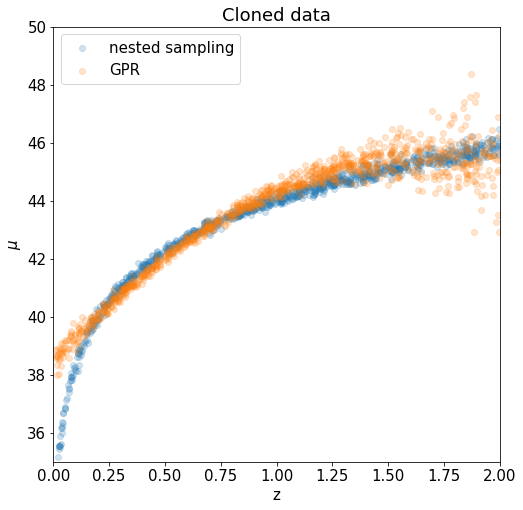

In [42]:
plt.scatter(z_vals,mu_nested,alpha=0.2,label="nested sampling")
plt.scatter(z_vals,mu_gpr,alpha=0.2,label='GPR')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.title("Cloned data")
plt.legend()

The key difference between the two is that the blue points are theory-informed, while the orange points are data-driven